In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

import text_utilities
import deep_learning_utils

from collections import Counter
import os
import random
import re
import string
import time

seed = 2137

random.seed = seed
tf.random.set_seed(seed)
np.random.seed(seed)

2024-07-18 17:50:19.313985: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset Import

In [3]:
path = '/Users/kuba/Desktop/PBL.nosync/deep_learning/data'

In [4]:
train = pd.read_csv(path + '/pseudo_bert_train.csv')
val = pd.read_csv(path + '/pseudo_bert_val.csv')
test = pd.read_csv(path + '/pseudo_bert_test.csv')

## Tensorflow Dataset Creation

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((train['text_processed'].values, train['relevant'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val['text_processed'].values, val['relevant'].values))
test_ds = tf.data.Dataset.from_tensor_slices((test['text_processed'].values, test['relevant'].values))

train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

 ## Optimize the Dataset

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling

## Modeling Utilities

In [7]:
output_dim = 512

vocab_size = 22000

def custom_standardization(input_text):
    """Lowercase and remove punctuation from the text."""
    lowercase_text = tf.strings.lower(input_text)
    cleaned_text = tf.strings.regex_replace(lowercase_text, '[%s]' % re.escape(string.punctuation), '')
    return cleaned_text

# Create the TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=output_dim,
    standardize=custom_standardization
)

# Assuming `texts` is a list or dataset of your text data
vectorize_layer.adapt(train['text_processed'])

In [11]:
import pickle

# Pickle the config and weights
pickle.dump({'config': vectorize_layer.get_config(),
             'weights': vectorize_layer.get_weights()}
            , open("lstm_vectorize_layer.pkl", "wb"))

In [19]:
metrics = ['accuracy', 'recall', 'precision', 'AUC']

epochs=20

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True, verbose=1)

## Model Registry

In [21]:
path_to_registry = r'model_results_table.csv'

if os.path.exists(path_to_registry):
    model_registry = pd.read_csv(path_to_registry, index_col=0).reset_index(drop=False)
else:
    model_registry = None

## LGBM with pseudo labels

In [11]:
# lgbm with parameters from parameters_dict

import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

lgb_params = {'colsample_bytree': 0.5527441519925319,
 'learning_rate': 0.05670501625777839,
 'max_depth': 13,
 'min_child_samples': 6,
 'n_estimators': 231,
 'num_leaves': 19,
 'reg_alpha': 0.028846140312283053,
 'reg_lambda': 0.5494358889794788,
 'subsample': 0.8310616529434425}

clf = lgb.LGBMClassifier(**lgb_params)


pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('classifier', clf)
])

In [12]:
pipe.fit(train['text_processed'], train['relevant'])

[LightGBM] [Info] Number of positive: 8869, number of negative: 13633
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.378285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 529396
[LightGBM] [Info] Number of data points in the train set: 22502, number of used features: 21154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.394143 -> initscore=-0.429931
[LightGBM] [Info] Start training from score -0.429931


Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.5527441519925319,
                                learning_rate=0.05670501625777839, max_depth=13,
                                min_child_samples=6, n_estimators=231,
                                num_leaves=19, reg_alpha=0.028846140312283053,
                                reg_lambda=0.5494358889794788,
                                subsample=0.8310616529434425))])

In [29]:
# evaluate lgb

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

y_pred = pipe.predict(test['text_processed'])

print(classification_report(test['relevant'], y_pred))

# accuracy recall precision f1-score auc

accuracy = accuracy_score(test['relevant'], y_pred)
recall = recall_score(test['relevant'], y_pred)

precision = precision_score(test['relevant'], y_pred)
f1 = f1_score(test['relevant'], y_pred)

auc = roc_auc_score(test['relevant'], y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1-score: {f1}')
print(f'AUC: {auc}')

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       190
           1       0.89      0.84      0.86       143

    accuracy                           0.89       333
   macro avg       0.89      0.88      0.88       333
weighted avg       0.89      0.89      0.89       333

Accuracy: 0.8858858858858859
Recall: 0.8391608391608392
Precision: 0.8888888888888888
F1-score: 0.8633093525179856
AUC: 0.8801067353698933


### LSTM with trainable embeddings

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 256, 200)  │  4,400,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64)        │     59,648 │ embedding_3[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,459,713 (17.01 MB)

 Trainable params: 4,459,713 (17.01 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 139s 190ms/step - AUC: 0.9532 - accuracy: 0.8890 - loss: 0.2379 - precision: 0.9105 - recall: 0.7686 - val_AUC: 0.8909 - val_accuracy: 0.7447 - val_loss: 0.5301 - val_precision: 0.6330 - val_recall: 0.9650
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 129s 183ms/step - AUC: 0.9914 - accuracy: 0.9592 - loss: 0.1107 - precision: 0.9317 - recall: 0.9638 - val_AUC: 0.9119 - val_accuracy: 0.8228 - val_loss: 0.4913 - val_precision: 0.7211 - val_recall: 0.9580
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 126s 179ms/step - AUC: 0.9971 - accuracy: 0.9803 - loss: 0.0576 - precision: 0.9693 - recall: 0.9784 - val_AUC: 0.9197 - val_accuracy: 0.8108 - val_loss: 0.5469 - val_precision: 0.7105 - val_recall: 0.9441
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 128s 182ms/step - AUC: 0.9990 - accuracy: 0.9903 - loss: 0.0317 - precision: 0.9857 - recall: 0.9878 - val_AUC: 0.9148 - val_accuracy: 0.8318 - val_loss: 0.7560 - val_precision: 0.7351

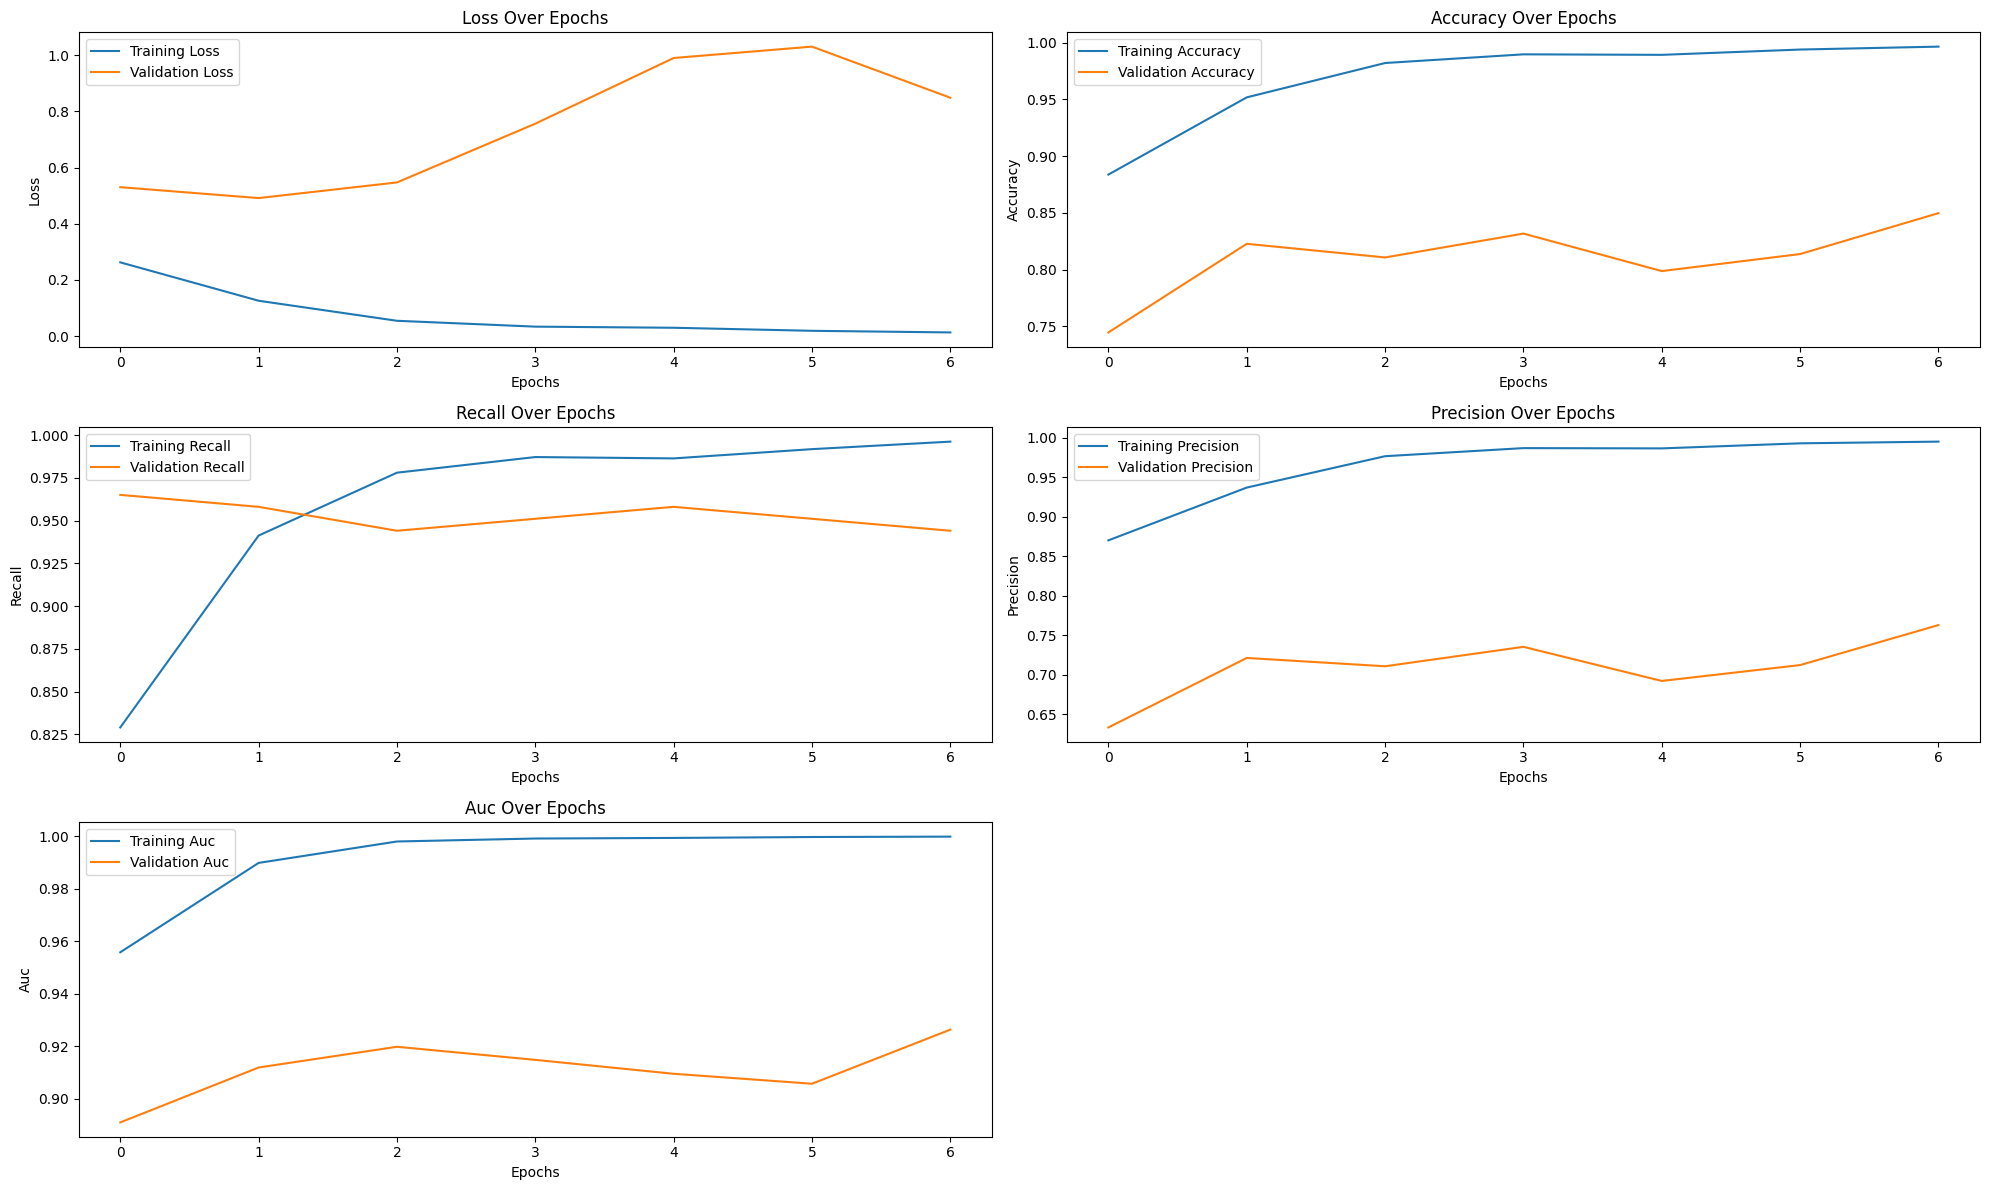


Final Training Loss: 0.0132
Final Validation Loss: 0.8483

Final Training Accuracy: 0.9966
Final Validation Accuracy: 0.8498

Final Training Recall: 0.9962
Final Validation Recall: 0.9441

Final Training Precision: 0.9952
Final Validation Precision: 0.7627

Final Training Auc: 0.9998
Final Validation Auc: 0.9263


*** EVALUATING MODEL ON TEST SET ***


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.9589 - accuracy: 0.8892 - loss: 0.4680 - precision: 0.7868 - recall: 0.9896
{'AUC': 0.9483069181442261, 'accuracy': 0.8768768906593323, 'loss': 0.531086802482605, 'precision': 0.7833333611488342, 'recall': 0.9860140085220337}
Test Loss: 0.531086802482605
Test Accuracy: 0.8768768906593323
Test Recall: 0.9860140085220337
Test Precision: 0.7833333611488342
Test Auc: 0.9483069181442261


In [24]:
model_bidir_1_no_reg = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                        embedding_dim=200,
                                        lstm_units=32,
                                        num_lstm_layers=1,
                                        num_classes=1,
                                        seed=seed,
                                        dropout_rate=0,
                                        l2_lambda=0,
                                        metrics = metrics,
                                        bidirectional=True)

model_bidir_1_no_reg.summary()

model_description = 'Bidirectional LSTM with 1 layer, 32 units, 200 embedding dim, no dropout, no l2 regularization'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_bidir_1_no_reg,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 256)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 256, 200)  │  4,400,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 256)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     59,648 │ embedding_2[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,459,713 (17.01 MB)

 Trainable params: 4,459,713 (17.01 MB)

 Non-trainable params: 0 (0.00 B)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 183s 249ms/step - AUC: 0.9173 - accuracy: 0.8381 - loss: 0.5098 - precision: 0.8539 - recall: 0.6575 - val_AUC: 0.8461 - val_accuracy: 0.6246 - val_loss: 0.8091 - val_precision: 0.5354 - val_recall: 0.9510
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 171s 243ms/step - AUC: 0.9660 - accuracy: 0.9073 - loss: 0.3660 - precision: 0.8543 - recall: 0.9104 - val_AUC: 0.8826 - val_accuracy: 0.6667 - val_loss: 0.7737 - val_precision: 0.5656 - val_recall: 0.9650
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 172s 244ms/step - AUC: 0.9711 - accuracy: 0.9180 - loss: 0.3392 - precision: 0.8760 - recall: 0.9088 - val_AUC: 0.8962 - val_accuracy: 0.6637 - val_loss: 0.7398 - val_precision: 0.5643 - val_recall: 0.9510
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 177s 251ms/step - AUC: 0.9725 - accuracy: 0.9211 - loss: 0.3215 - precision: 0.8792 - recall: 0.9145 - val_AUC: 0.9009 - val_accuracy: 0.6847 - val_loss: 0.7252 - val_precision: 0.5805

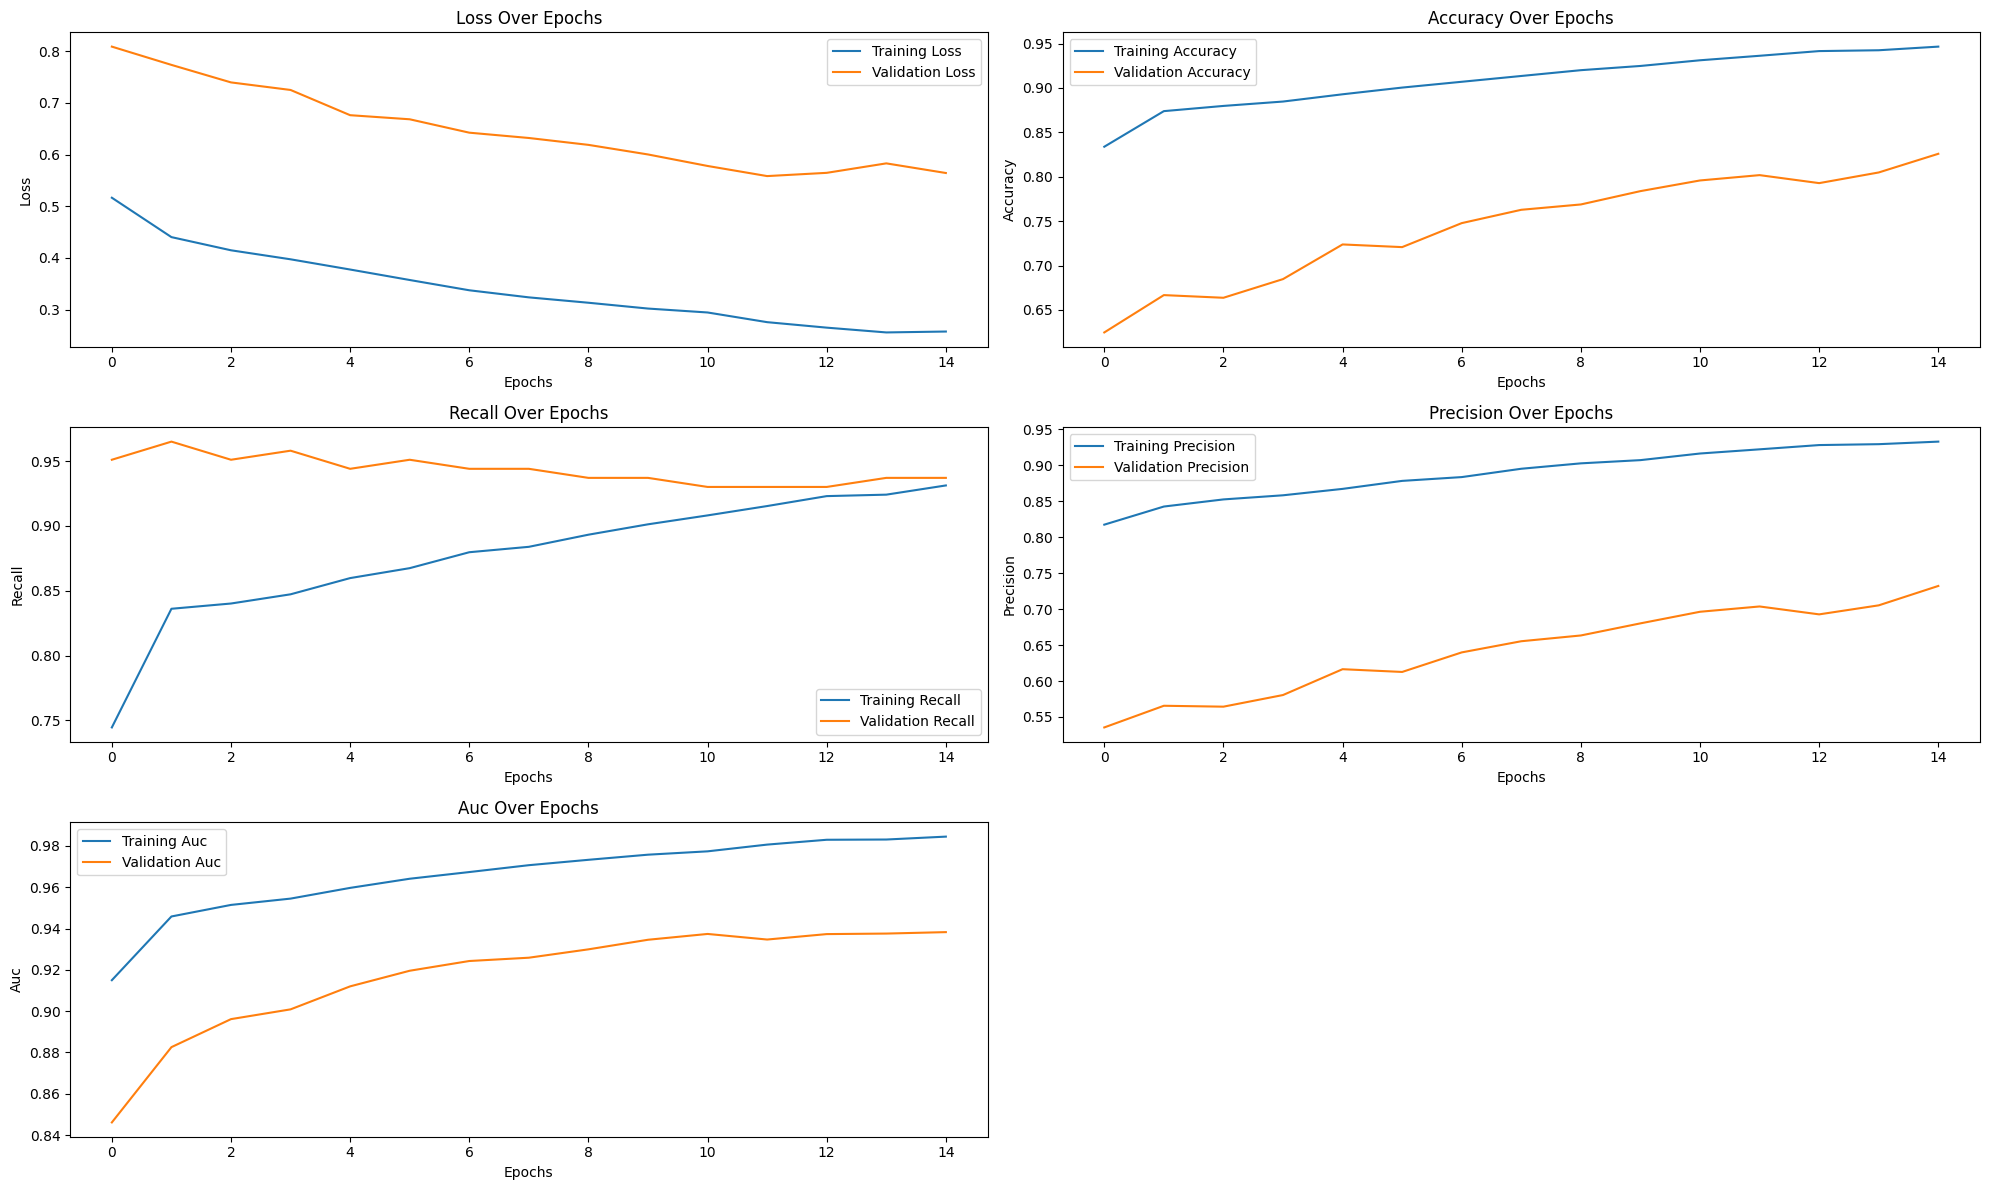


Final Training Loss: 0.2575
Final Validation Loss: 0.5644

Final Training Accuracy: 0.9465
Final Validation Accuracy: 0.8258

Final Training Recall: 0.9312
Final Validation Recall: 0.9371

Final Training Precision: 0.9330
Final Validation Precision: 0.7322

Final Training Auc: 0.9845
Final Validation Auc: 0.9383


*** EVALUATING MODEL ON TEST SET ***


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.9653 - accuracy: 0.8735 - loss: 0.4588 - precision: 0.7708 - recall: 0.9670
{'AUC': 0.9545637965202332, 'accuracy': 0.8558558821678162, 'loss': 0.4785975217819214, 'precision': 0.7624309659004211, 'recall': 0.9650349617004395}
Test Loss: 0.4785975217819214
Test Accuracy: 0.8558558821678162
Test Recall: 0.9650349617004395
Test Precision: 0.7624309659004211
Test Auc: 0.9545637965202332


In [23]:
model_bidir_1 = deep_learning_utils.create_lstm_model(vectorize_layer=vectorize_layer,
                                        embedding_dim=200,
                                        lstm_units=32,
                                        num_lstm_layers=1,
                                        num_classes=1,
                                        seed=seed,
                                        dropout_rate=0.3,
                                        l2_lambda=0.001,
                                        metrics = metrics,
                                        bidirectional=True)

model_bidir_1.summary()

model_description = '[PseudoL] One Layer Bidirectional LSTM (32), No Regularisation, Embeddings size: 200'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_bidir_1,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )